## Covid 19 Tweet Sentiment Analysis
 ### Dataset:
 #### 1)The dataset contains tweets from twitter users across globe about the covid 19 pandemic
 #### 2)It also contains the associated sentiment with the tweet along with the username,location and date

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
import string
from wordcloud import WordCloud, STOPWORDS
import collections
import spacy

/Users/praveshpradheep/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
stop_words = spacy.lang.en.STOP_WORDS

In [41]:
negative_words = set(['not', 'no', 'don', "don't", 'shouldn', "shouldn't", 'couldn', "couldn't"])
stop_words = stop_words - negative_words

In [4]:
df_train = pd.read_csv('DATA/Corona_NLP_train.csv',encoding='ISO-8859-1')

In [5]:
df_test = pd.read_csv('DATA/Corona_NLP_test.csv')

In [6]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [8]:
print("Training data has {} columns , {} rows".format(df_train.shape[1],df_train.shape[0]))
print("Test data has {} columns , {} rows".format(df_test.shape[1],df_test.shape[0]))

Training data has 6 columns , 41157 rows
Test data has 6 columns , 3798 rows


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [11]:
df_train['TweetAt'] = df_train['TweetAt'].astype('datetime64')

/var/folders/zh/vbh47d_10r73x8tsyq9ndp9r0000gn/T/ipykernel_22139/3726654556.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_train['TweetAt'] = df_train['TweetAt'].astype('datetime64')


In [12]:
print("Tweets in train data range from {} to {}".format(min(df_train['TweetAt']),max(df_train['TweetAt'])))

Tweets in train data range from 2020-01-04 00:00:00 to 2020-12-04 00:00:00


In [13]:
df_train['month'] = df_train['TweetAt'].apply(lambda x: x.strftime("%B"))

In [14]:
sns.set(rc={'figure.figsize':(11.7,8.20)})

<Axes: xlabel='Sentiment', ylabel='count'>

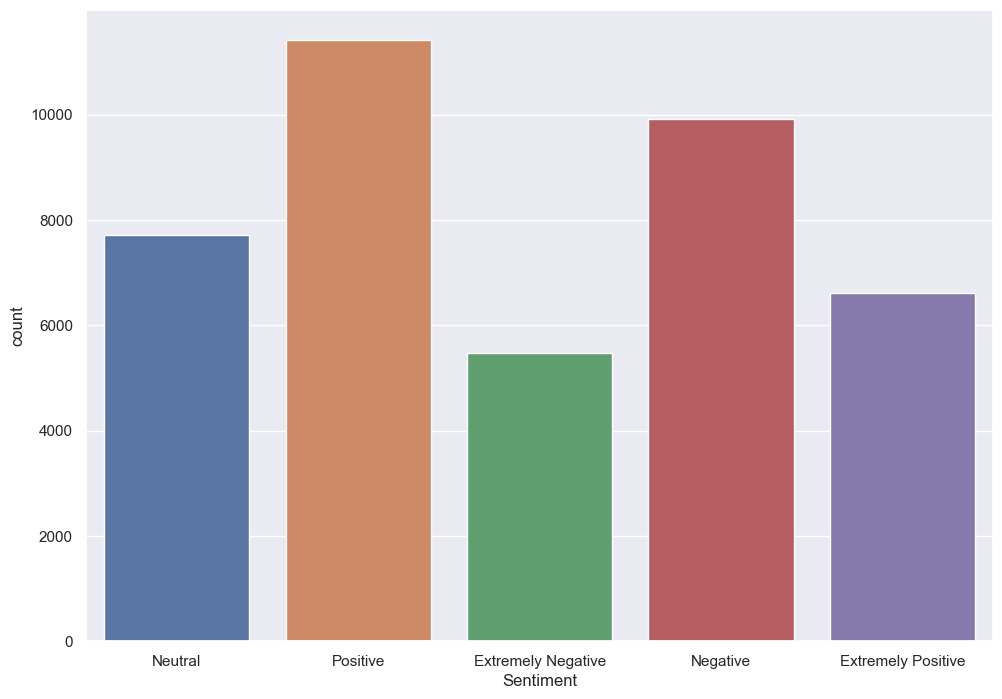

In [15]:
sns.countplot(x=df_train['Sentiment'])

<Axes: xlabel='month', ylabel='count'>

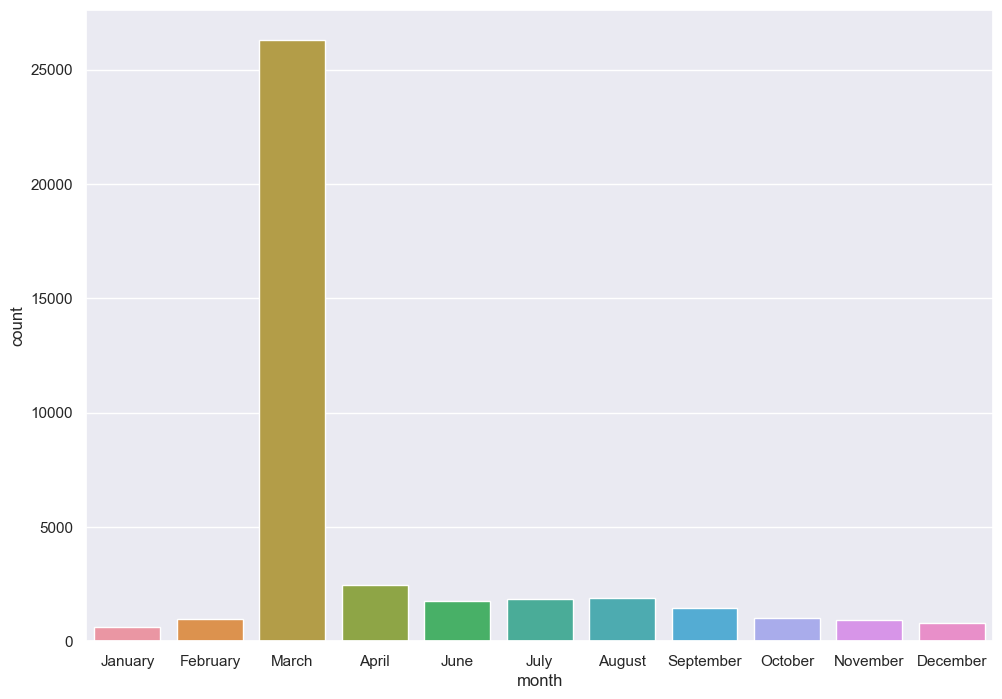

In [16]:
sns.countplot(x=df_train['month'],order=['January','February','March','April','June','July','August','September','October','November','December'])

<Axes: xlabel='month', ylabel='count'>

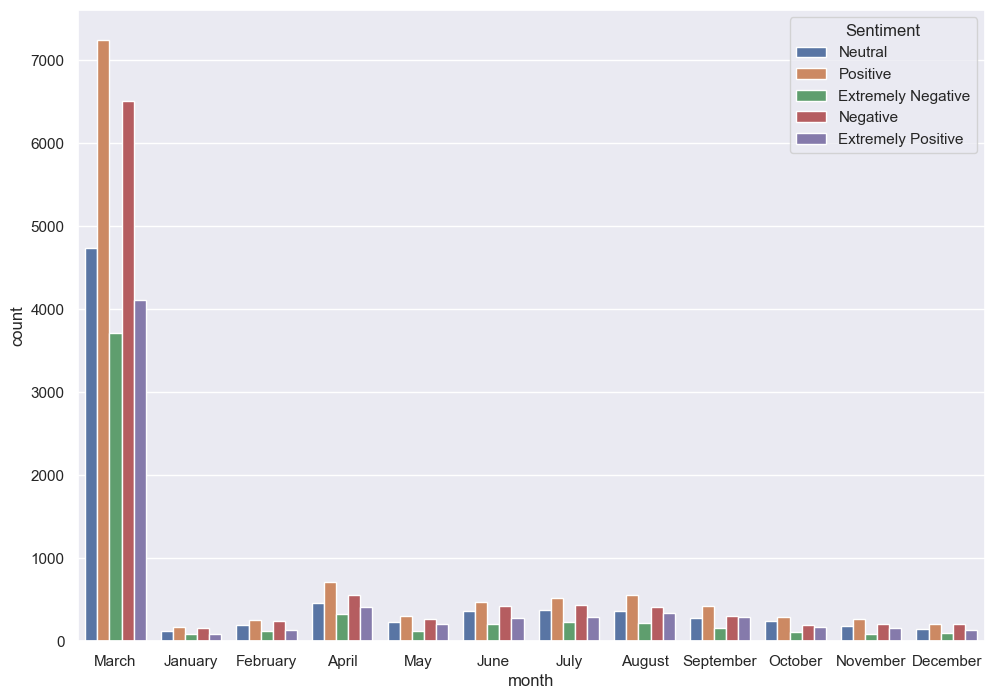

In [17]:
sns.countplot(x=df_train['month'],hue=df_train['Sentiment'])

## Data Cleaning

In [29]:
class cleanText:
    """
        Class to help clean the input text by remove hastags,emails,retweets,html,special characters,emojis,punctations 
        from text
        Parameters
        -----------
            texts: array of shape(n_samples,)
        Returns
        -------
            cleaned_texts: array of shape(n_samples,) with cleaned texts
    """
    def __init__(self,texts=None):
        self.texts = texts
        
    def remove_hastags(self,text):
        """
        function to remove hastags from the tweets
        """
        return re.sub(r'#\w*', ' ' , text)

    def remove_urls(self,text):
        """
        function to removes web urls from the tweets
        """
        return re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", '', text)
    
    def remove_email(self,text):
        """
        function to remove email address from tweets
        """
        return re.sub(r'\S+@\S+', '', text)

    def remove_rts(self,text):
        """
        This function removes the retweets from the tweets
        """
        return re.sub(r'@\w+\b',' ',text)

    def remove_special_chars(self,text):
        """
        This function remove any special characters from the tweet
        """
        return re.sub(r"[^a-zA-Z0-9\s]",' ',text)
    
    def tokenize_text(self,text):
        """
        function to tokenizes the input text
        """
        return re.split(r'\s+',text)
    
    def remove_html(self,text):
        """
        function to remove html tags from the tweets
        """
        soup = BeautifulSoup(text, 'lxml')
        text = soup.get_text()
        return text
    
    def decontracted(self,phrase):
        """
        function to expand phrases
        """
        # specific
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"\bu\b", "you", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase
    
    def convert_to_lowercase(self,tokens):
        """
        function to convert text into lowercase
        """
        return [token.lower() for token in tokens if token.isalpha()]
    
    def remove_single_length_tokens(self,tokens):
        """
        function to remove single character tokens
        """
        return [token for token in tokens if len(token)>1]
    
    def remove_punctuation(self,text):
        """
        function to remove punctuations in text
        """
        return re.sub('['+string.punctuation+']', '', text)
    
    def remove_emojis(self,text):
        reemoji_pattern = re.compile(
            u"(\ud83d[\ude00-\ude4f])|"  # emoticons
            u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
            u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
            u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
            u"(\ud83c[\udde0-\uddff])"  # flags (iOS)
            "+", flags=re.UNICODE)
        return reemoji_pattern.sub(r'',text)
    
        
    def clean_text(self):
        cleaned_texts = []
        for text in tqdm(self.texts):
            text_without_link = self.remove_urls(text)
            text_without_hastags = self.remove_hastags(text_without_link)
            text_without_rts = self.remove_rts(text_without_hastags)
            text_without_email = self.remove_email(text_without_rts)
            text_without_html = self.remove_html(text_without_email)
            text_without_emojis = self.remove_emojis(text_without_html)
            text_without_punct = self.remove_punctuation(text_without_emojis)
            text_decontracted = self.decontracted(text_without_punct)
            text_without_special_chars = self.remove_special_chars(text_decontracted)
            tokens = self.tokenize_text(text_without_special_chars)
            lowercase_tokens = self.convert_to_lowercase(tokens)
            non_single_char_tokens = self.remove_single_length_tokens(lowercase_tokens)
            clean_text = " ".join(non_single_char_tokens)
            cleaned_texts.append(clean_text)
        return cleaned_texts

In [30]:
processText = cleanText(texts=df_train.OriginalTweet.values.tolist())
cleanedTextTrain = processText.clean_text()

  0%|                                                                                                                                                                                 | 0/41157 [00:00<?, ?it/s]/Users/praveshpradheep/anaconda3/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41157/41157 [00:04<00:00, 9129.54it/s]


In [31]:
cleanedTextTrain[0]

'and and'

In [32]:
df_train.OriginalTweet.values.tolist()[0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [33]:
df_train['OriginalTweetClean'] = cleanedTextTrain

#### Wordcloud

In [34]:
def generate_wordcloud(texts,title=None):
    text = ' '.join(texts)
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(max_words=1500,
                          background_color ='white',
                          stopwords = stopwords,
                          max_font_size = 50).generate(text)
    plt.figure(figsize = (5, 5), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title, fontsize=23)
    plt.show()

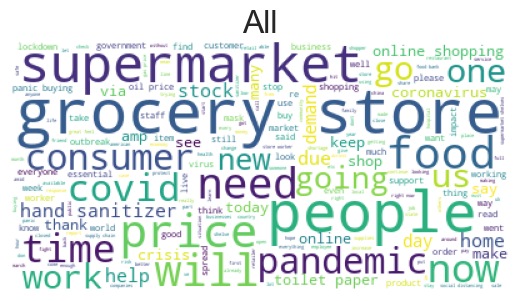

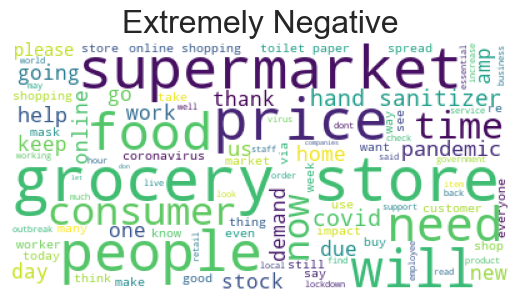

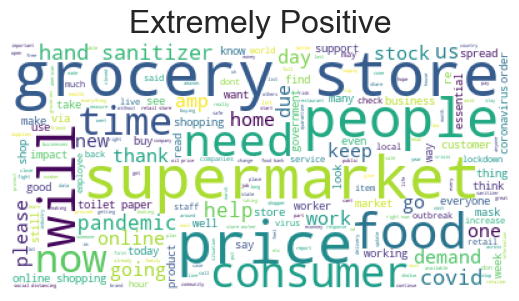

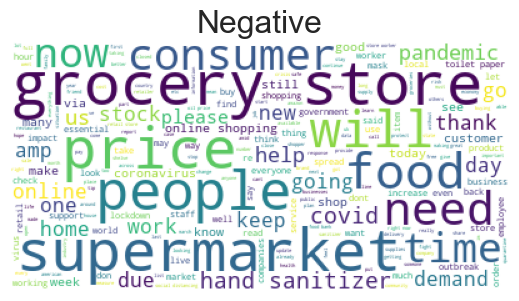

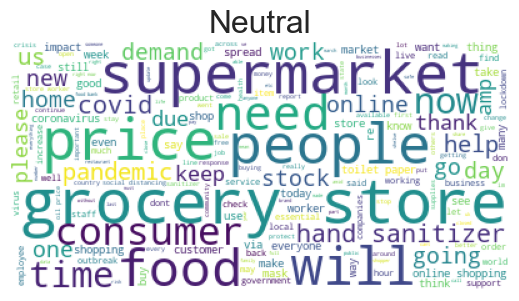

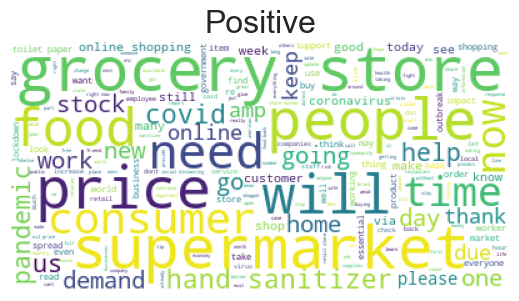

In [35]:
generate_wordcloud(cleanedTextTrain,"All")
print()
sentiments = np.unique(df_train.Sentiment.values.tolist())
for sentiment in sentiments:
    indices = list(df_train[df_train['Sentiment']=='Positive'].index)
    texts = [cleanedTextTrain[i] for i in indices]
    generate_wordcloud(texts,sentiment)
    print()

In [36]:
def plot_most_and_least_freq_words(texts):
    texts = " ".join(texts)
    words = texts.lower().split()
    word_count = collections.Counter(words)
    most_common = word_count.most_common(50)
    least_common = sorted(word_count.items(), key=lambda x: x[1])[:50]
    #plot most common words
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar([word[0] for word in most_common], [word[1] for word in most_common])
    ax.set_title('Top 50 most frequent words')
    ax.set_xlabel('Words')
    ax.set_ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()
    #plot least common words
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, prefer_horizontal=0.7).generate_from_frequencies(dict(least_common))
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Top 50 least frequent words')
    plt.show()

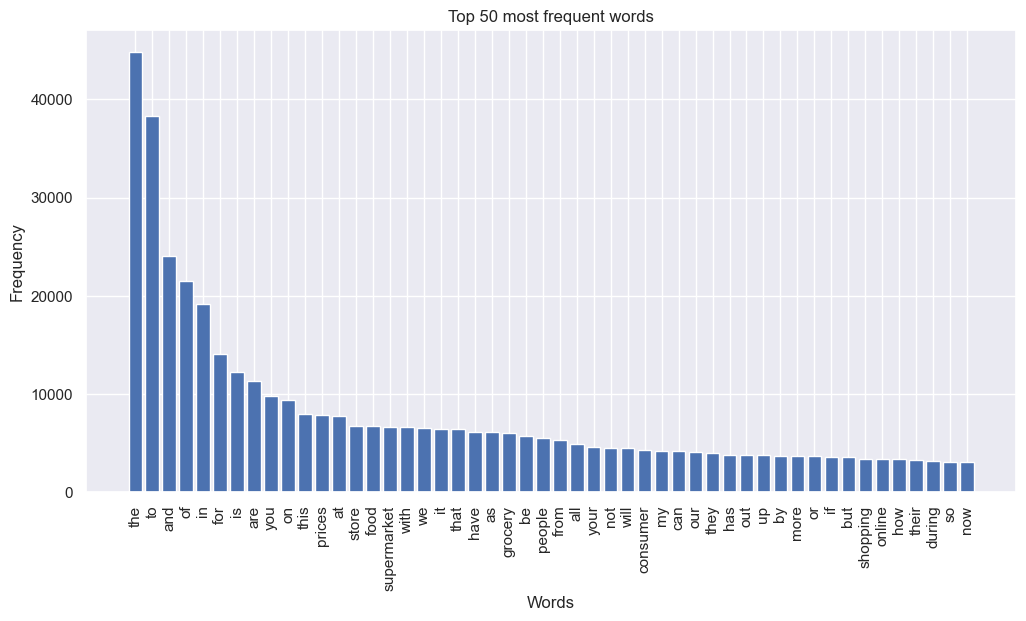

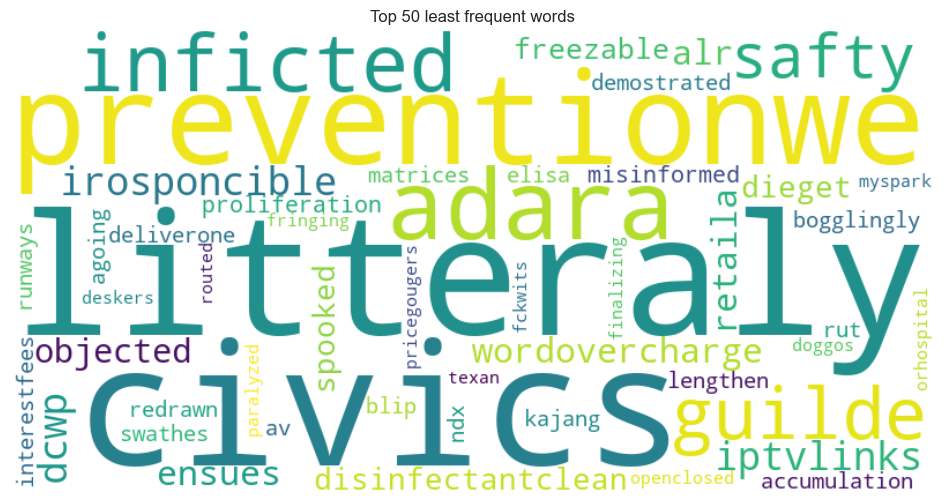

In [37]:
plot_most_and_least_freq_words(cleanedTextTrain)

### Text Normalizing

#### STOP WORDS

In [38]:
def remove_stop_words(text):
    """
    function to remove stop words from text
    Parameters
    ----------
    text: A single record/line of text
    
    Returns
    -------
    The text after removing all stop words
    """
    tokens = re.split('\s+',text)
    filtered_text = [token for token in tokens if token not in stop_words]
    return " ".join(filtered_text)

def get_lemmatized_text(text):
    """
    function to lemmatize the input text. Lemmatization is the process of breaking down word to it's root form
    Parameters
    ----------
    text: A single record/line of text
    
    Returns
    -------
    The text after applying lemmatization
    
    """
    doc = nlp(text)
    lemmatized_text = [token.lemma_ for token in doc]
    return " ".join(lemmatized_text)

In [43]:
df_train['OriginalTweetClean'] = df_train['OriginalTweetClean'].apply(remove_stop_words)
df_train['OriginalTweetClean'] = df_train['OriginalTweetClean'].apply(get_lemmatized_text)

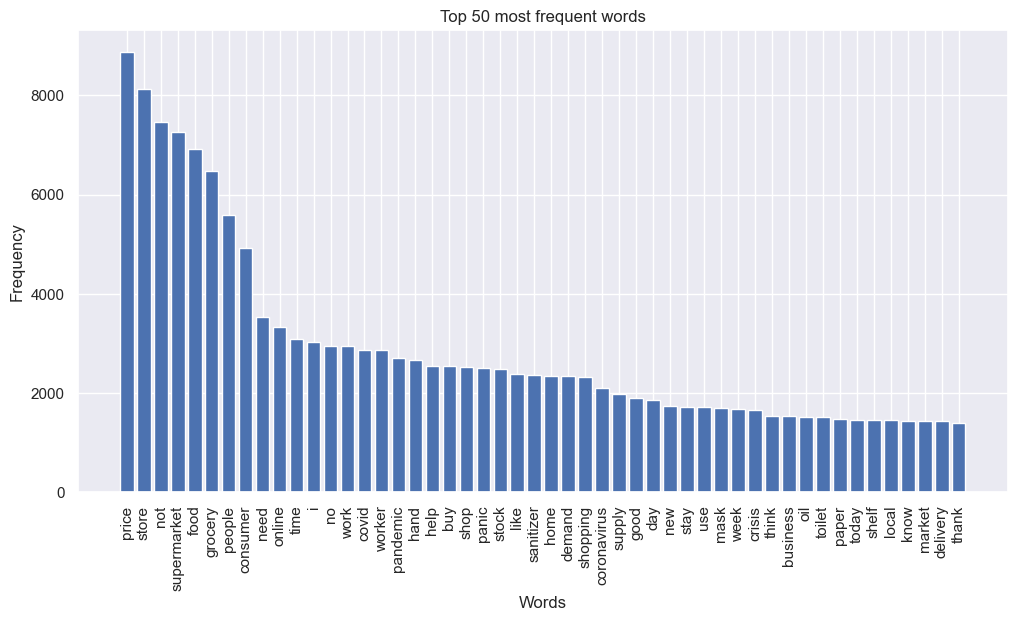

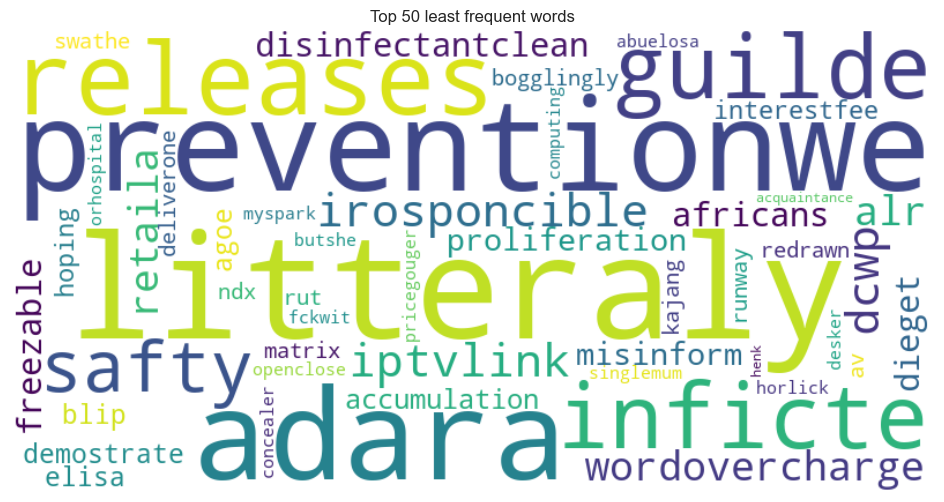

In [44]:
plot_most_and_least_freq_words(df_train['OriginalTweetClean'].values.tolist())

In [45]:
label_dict = {'Positive': 0, 'Extremely Positive': 1, 'Neutral': 2, 'Negative': 3, 'Extremely Negative': 4}

In [46]:
df_train['Sentiment'] = df_train['Sentiment'].apply(lambda x: label_dict[x])

In [47]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,OriginalTweetClean
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,March,
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,0,March,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,0,March,coronavirus australia woolworth elderly disabl...
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,0,March,food stock not not panic food not need stay ca...
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",4,March,I ready supermarket outbreak not I m paranoid ...


In [52]:
df_train['OriginalTweetClean'] = df_train['OriginalTweetClean'].replace('',None)

In [53]:
df_train.dropna(subset=['OriginalTweetClean'],inplace=True)

In [54]:
df_train.shape

(41078, 8)

In [84]:
train_texts = df_train.OriginalTweetClean.values.tolist()
train_labels = df_train.Sentiment.values.tolist()

## TF-IDF Vectorizer

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [78]:
tfidf_vectorizer = TfidfVectorizer(min_df=10,max_df=0.9)

In [79]:
tfidf_vectorizer.fit(train_texts)

TfidfVectorizer(max_df=0.9, min_df=10)

In [80]:
tfidf_model = tfidf_vectorizer.transform(train_texts)

In [81]:
print("Number of unique words in the corpus is {}".format(tfidf_model.shape[1]))

Number of unique words in the corpus is 4401


In [85]:
X_train,X_test,y_train,y_test = train_test_split(tfidf_model.tocsr(),train_labels,train_size=0.8,shuffle=True)

### Multinomial NB